In [1]:
!pip install torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv h5py -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                          

In [2]:
!pip install h5py

In [14]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

In [15]:
# ============================================================================
# 2.1) Cargar el tensor de entrada (final_tensor_temporal)
#     Esperamos forma (num_samples=406, num_nodes=146, 4, 81)
# ============================================================================
with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())  # p.ej. 146
    node_tensors = []

    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # (410, 81)
        time_steps = data.shape[0]

        sliding_windows = []
        for t in range(4, time_steps):
            window = data[t-4:t]  # (4, 81)
            sliding_windows.append(window)

        node_tensor = np.stack(sliding_windows)  # (time_steps-4, 4, 81)
        node_tensors.append(node_tensor)

    final_tensor_temporal = np.stack(node_tensors, axis=1)  # (406, 146, 4, 81)

print("Shape del tensor final de entrada (X):", final_tensor_temporal.shape)

# ============================================================================
# 2.2) Cargar el tensor de adyacencia (adjacency_tensor)
#     Esperamos forma (num_samples=406, 4, num_nodes=146, num_nodes=146)
# ============================================================================
with h5py.File("matrices_adyacencia.h5", "r") as h5_file:
    time_keys = sorted(h5_file.keys(), key=lambda x: int(x))
    num_time_steps = len(time_keys)  # p.ej. 410
    num_windows = num_time_steps - 4
    num_nodes_check = h5_file[time_keys[0]].shape[0]  # 146

    adjacency_tensor = np.zeros((num_windows, 4, num_nodes_check, num_nodes_check))

    for window_idx, t in enumerate(range(4, num_time_steps)):
        window = []
        for i in range(4):
            time_key = time_keys[t - 4 + i]
            adj_mat = h5_file[time_key][()]
            window.append(adj_mat)
        adjacency_tensor[window_idx] = np.stack(window)

print("Shape del tensor de adyacencia (A):", adjacency_tensor.shape)

# ============================================================================
# 2.3) Cargar el tensor de salida (final_output_tensor)
#     Esperamos forma (num_samples=406, num_nodes=146, 1, 81)
# ============================================================================
with h5py.File("data_temporal.h5", "r") as h5_file:
    num_nodes = len(h5_file.keys())
    output_tensors = []

    for key in range(num_nodes):
        data = h5_file[str(key)][()]  # (410, 81)
        time_steps = data.shape[0]

        targets = []
        for t in range(4, time_steps):
            target = data[t]  # (81,)
            targets.append(target)

        node_targets = np.array(targets).reshape(-1, 1, 81)  # (406,1,81)
        output_tensors.append(node_targets)

    final_output_tensor = np.stack(output_tensors, axis=1)  # (406,146,1,81)

print("Shape del tensor de salida (Y):", final_output_tensor.shape)


Shape del tensor final de entrada (X): (406, 146, 4, 81)
Shape del tensor de adyacencia (A): (406, 4, 146, 146)
Shape del tensor de salida (Y): (406, 146, 1, 81)


In [16]:
# ============================================================================
# 3.1) Definición del Dataset (x, A, y)
# ============================================================================
class SpatioTemporalDataset(Dataset):
    def __init__(self, input_data, adjacency_data, output_data):
        # input_data:    (num_samples, num_nodes, 4, 81)
        # adjacency_data:(num_samples, 4, num_nodes, num_nodes)
        # output_data:   (num_samples, num_nodes, 1, 81)
        self.input_data = torch.tensor(input_data, dtype=torch.float32)
        self.adjacency_data = torch.tensor(adjacency_data, dtype=torch.float32)
        self.output_data = torch.tensor(output_data, dtype=torch.float32)

    def __len__(self):
        return self.input_data.shape[0]

    def __getitem__(self, idx):
        return (
            self.input_data[idx],      # (num_nodes, 4, 81)
            self.adjacency_data[idx],  # (4, num_nodes, num_nodes)
            self.output_data[idx]      # (num_nodes, 1, 81)
        )

dataset = SpatioTemporalDataset(final_tensor_temporal, adjacency_tensor, final_output_tensor)

# ============================================================================
# 3.2) División estratificada temporal: 80% train, 10% val, 10% test
# ============================================================================
num_samples = len(dataset)  # ~406
train_size = int(0.8 * num_samples)
val_size   = int(0.1 * num_samples)
test_size  = num_samples - train_size - val_size

train_indices = list(range(0, train_size))
val_indices   = list(range(train_size, train_size + val_size))
test_indices  = list(range(train_size + val_size, num_samples))

train_subset = Subset(dataset, train_indices)
val_subset   = Subset(dataset, val_indices)
test_subset  = Subset(dataset, test_indices)

# ============================================================================
# 3.3) Cálculo de min y max en el set de entrenamiento
#      Para normalizar x (features) y y (targets)
# ============================================================================
train_input = dataset.input_data[train_indices]   # (train_size, num_nodes, 4, 81)
train_output= dataset.output_data[train_indices]  # (train_size, num_nodes, 1, 81)
train_adj   = dataset.adjacency_data[train_indices]# (train_size, 4, num_nodes, num_nodes)

# Min y max en dimensión de features (81)
input_min = torch.amin(train_input, dim=(0,1,2), keepdim=False)  # (81,)
input_max = torch.amax(train_input, dim=(0,1,2), keepdim=False)  # (81,)
output_min= torch.amin(train_output,dim=(0,1,2), keepdim=False)  # (81,)
output_max= torch.amax(train_output,dim=(0,1,2), keepdim=False)  # (81,)

# Para la adyacencia, sacamos min y max global
adj_min = torch.amin(train_adj)
adj_max = torch.amax(train_adj)

# ============================================================================
# 3.4) Dataset normalizado
# ============================================================================
class NormalizedDataset(Dataset):
    def __init__(self, subset, input_min, input_max, output_min, output_max, adj_min, adj_max):
        self.subset = subset
        self.input_min = input_min
        self.input_max = input_max
        self.output_min = output_min
        self.output_max = output_max
        self.adj_min = adj_min
        self.adj_max = adj_max

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, A, y = self.subset[idx]

        # x: (num_nodes, 4, 81)
        # Normalizar en la última dimensión (81)
        # Expand para broadcast
        x_norm = (x - self.input_min) / (self.input_max - self.input_min + 1e-8)
        y_norm = (y - self.output_min) / (self.output_max - self.output_min + 1e-8)

        # A: (4, num_nodes, num_nodes) -> escalar a [-1,1]
        A_norm = 2 * ((A - self.adj_min) / (self.adj_max - self.adj_min + 1e-8)) - 1

        return x_norm, A_norm, y_norm

train_dataset = NormalizedDataset(train_subset, input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)
val_dataset   = NormalizedDataset(val_subset,   input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)
test_dataset  = NormalizedDataset(test_subset,  input_min, input_max,
                                  output_min, output_max, adj_min, adj_max)

# ============================================================================
# 3.5) Dataloaders
# ============================================================================
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:  ", len(val_dataset))
print("Test samples: ", len(test_dataset))


Train samples: 324
Val samples:   40
Test samples:  42


In [17]:

def compute_random_walk_matrix(adj_matrix):
    """
    Calcula la matriz de random-walk fila-normalizada: D^-1 * A
    adj_matrix: (num_nodes, num_nodes)
    """
    # A >= 0
    d = torch.sum(adj_matrix, dim=-1)  # (num_nodes,)
    # Evitar división por cero
    d_inv = 1.0 / (d + 1e-8)
    d_inv = torch.diag(d_inv)
    rw_mat = d_inv @ adj_matrix
    return rw_mat

def diffusion_convolution(x, adj_rw, adj_rw_T, k):
    """
    Aplica la difusión de orden k sobre x usando la random-walk matrix (adj_rw)
    y su traspuesta (adj_rw_T).
    x: (num_nodes, in_features)
    adj_rw: (num_nodes, num_nodes)
    adj_rw_T: (num_nodes, num_nodes)
    k: orden de la difusión
    Retorna un tensor concatenado con [x, adj_rw*x, adj_rw^2*x, ..., adj_rw^k*x,
                                      adj_rw_T*x, adj_rw_T^2*x, ..., adj_rw_T^k*x]
    """
    # x_0 = x
    out = [x]
    x_rw = x
    x_rw_t = x
    for _ in range(1, k+1):
        # Multiplicación de difusión
        x_rw = adj_rw @ x_rw
        x_rw_t = adj_rw_T @ x_rw_t
        out.append(x_rw)
        out.append(x_rw_t)
    return torch.cat(out, dim=-1)  # concatena en la dimensión de features


In [18]:
class DCGRUCell(nn.Module):
    def __init__(self, num_nodes, in_features, out_features, k=2):
        """
        num_nodes: número de nodos
        in_features: dimensión de entrada (features) en cada nodo
        out_features: dimensión oculta (hidden size)
        k: orden de la difusión
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.in_features = in_features
        self.out_features = out_features
        self.k = k

        # Para la difusión, la entrada real al GRU será ( (k*2 + 1)*in_features )
        # (k*2 + 1) porque k órdenes forward, k órdenes backward y x_0
        self.diffusion_features = (2*k + 1) * in_features

        # Matrices de la GRU (update, reset, candidate)
        self.update_gate = nn.Linear(self.diffusion_features + out_features, out_features)
        self.reset_gate  = nn.Linear(self.diffusion_features + out_features, out_features)
        self.candidate   = nn.Linear(self.diffusion_features + out_features, out_features)

    def forward(self, x, h, adj):
        """
        x: (num_nodes, in_features)
        h: (num_nodes, out_features) hidden state
        adj: (num_nodes, num_nodes) -> se usará para computar la difusión
        """
        # 1) Creamos la matriz random-walk y su traspuesta
        adj_rw = compute_random_walk_matrix(adj)
        adj_rw_T = compute_random_walk_matrix(adj.transpose(0,1))

        # 2) diffusion convolution => (num_nodes, diffusion_features)
        x_diffused = diffusion_convolution(x, adj_rw, adj_rw_T, self.k)

        # 3) Concatenamos con h
        combined = torch.cat([x_diffused, h], dim=-1)  # (num_nodes, diffusion_features + out_features)

        # 4) GRU gating
        z = torch.sigmoid(self.update_gate(combined))
        r = torch.sigmoid(self.reset_gate(combined))
        hc_input = torch.cat([x_diffused, r * h], dim=-1)
        hc = torch.tanh(self.candidate(hc_input))

        h_new = (1 - z) * h + z * hc
        return h_new



In [19]:
class DCRNN(nn.Module):
    def __init__(self, num_nodes, in_features, rnn_hidden, out_features, k=2):
        """
        num_nodes:   número de nodos
        in_features: dimensión de entrada (p.ej. 81)
        rnn_hidden:  dimensión oculta del DCGRU
        out_features: dimensión de salida final (p.ej. 81)
        k: orden de difusión
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.in_features = in_features
        self.rnn_hidden = rnn_hidden
        self.out_features= out_features
        self.k = k

        # Celda DCGRU
        self.dcgru_cell = DCGRUCell(num_nodes, in_features, rnn_hidden, k)

        # Proyección final: hidden -> out_features
        self.fc_out = nn.Linear(rnn_hidden, out_features)

    def forward(self, x, A):
        """
        x: (batch_size, num_nodes, T, in_features)
        A: (batch_size, T, num_nodes, num_nodes)
        Retorna: (batch_size, num_nodes, 1, out_features)
        """
        device = x.device
        B, N, T, F_in = x.shape

        # h inicial
        h = torch.zeros(B, N, self.rnn_hidden, device=device)

        # Desenrollado en T pasos
        for t in range(T):
            # x_t: (B, N, in_features)
            x_t = x[:, :, t, :]
            A_t = A[:, t, :, :]  # (B, N, N)

            h_new = []
            # Procesamos cada muestra en el batch
            for b_idx in range(B):
                # DCGRUCell es (num_nodes, in_features) -> (num_nodes, hidden)
                h_b = self.dcgru_cell(x_t[b_idx], h[b_idx], A_t[b_idx])
                h_new.append(h_b)
            h = torch.stack(h_new, dim=0)  # (B, N, hidden)

        # Al final de T pasos, h es (B, N, hidden)
        # Proyectamos a out_features
        out = self.fc_out(h)  # (B, N, out_features)

        # Reorganizamos a (B, N, 1, out_features)
        out = out.unsqueeze(2)
        return out


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Instancia DCRNN
model = DCRNN(
    num_nodes=146,      # Ajusta si tu dataset tiene distinto número de nodos
    in_features=81,     # features de entrada
    rnn_hidden=32,      # tamaño oculto (puedes probar 32, 64, etc.)
    out_features=81,    # queremos predecir 81 features
    k=2                 # orden de difusión
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 150
best_val_loss = float("inf")
best_model_state_dict = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for x_batch, A_batch, y_batch in train_loader:
        x_batch, A_batch, y_batch = x_batch.to(device), A_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # Forward
        y_pred = model(x_batch, A_batch)  # (B, N, 1, 81)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, A_val, y_val in val_loader:
            x_val, A_val, y_val = x_val.to(device), A_val.to(device), y_val.to(device)
            y_pred_val = model(x_val, A_val)
            val_loss += criterion(y_pred_val, y_val).item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    # Guardado del mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

if best_model_state_dict is not None:
    torch.save(best_model_state_dict, "Mejor_modelo_dcrnn.pth")
    print("Se guardó el mejor modelo con val_loss =", best_val_loss)


Usando dispositivo: cpu
Epoch [1/150] - Train Loss: 0.0113 - Val Loss: 0.0095
Epoch [2/150] - Train Loss: 0.0071 - Val Loss: 0.0059
Epoch [3/150] - Train Loss: 0.0048 - Val Loss: 0.0047
Epoch [4/150] - Train Loss: 0.0041 - Val Loss: 0.0043
Epoch [5/150] - Train Loss: 0.0038 - Val Loss: 0.0041
Epoch [6/150] - Train Loss: 0.0036 - Val Loss: 0.0039
Epoch [7/150] - Train Loss: 0.0035 - Val Loss: 0.0038
Epoch [8/150] - Train Loss: 0.0033 - Val Loss: 0.0037
Epoch [9/150] - Train Loss: 0.0032 - Val Loss: 0.0035
Epoch [10/150] - Train Loss: 0.0031 - Val Loss: 0.0034
Epoch [11/150] - Train Loss: 0.0030 - Val Loss: 0.0033
Epoch [12/150] - Train Loss: 0.0029 - Val Loss: 0.0032
Epoch [13/150] - Train Loss: 0.0028 - Val Loss: 0.0031
Epoch [14/150] - Train Loss: 0.0027 - Val Loss: 0.0031
Epoch [15/150] - Train Loss: 0.0027 - Val Loss: 0.0030
Epoch [16/150] - Train Loss: 0.0026 - Val Loss: 0.0029
Epoch [17/150] - Train Loss: 0.0025 - Val Loss: 0.0028
Epoch [18/150] - Train Loss: 0.0025 - Val Loss: 0.

In [24]:

# Carga del mejor modelo
model.load_state_dict(torch.load("Mejor_modelo_dcrnn.pth"))
model.eval()

test_loss = 0.0
with torch.no_grad():
    for x_test, A_test, y_test in test_loader:
        x_test, A_test, y_test = x_test.to(device), A_test.to(device), y_test.to(device)
        y_pred_test = model(x_test, A_test)
        test_loss += criterion(y_pred_test, y_test).item()

test_loss /= len(test_loader)
print(f"Pérdida en Test: {test_loss:.4f}")



<ipython-input-24-e57fa765a9bf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_dcrnn.pth"))


Pérdida en Test: 0.0014


<ipython-input-36-7f56c788c41a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Mejor_modelo_dcrnn.pth"))


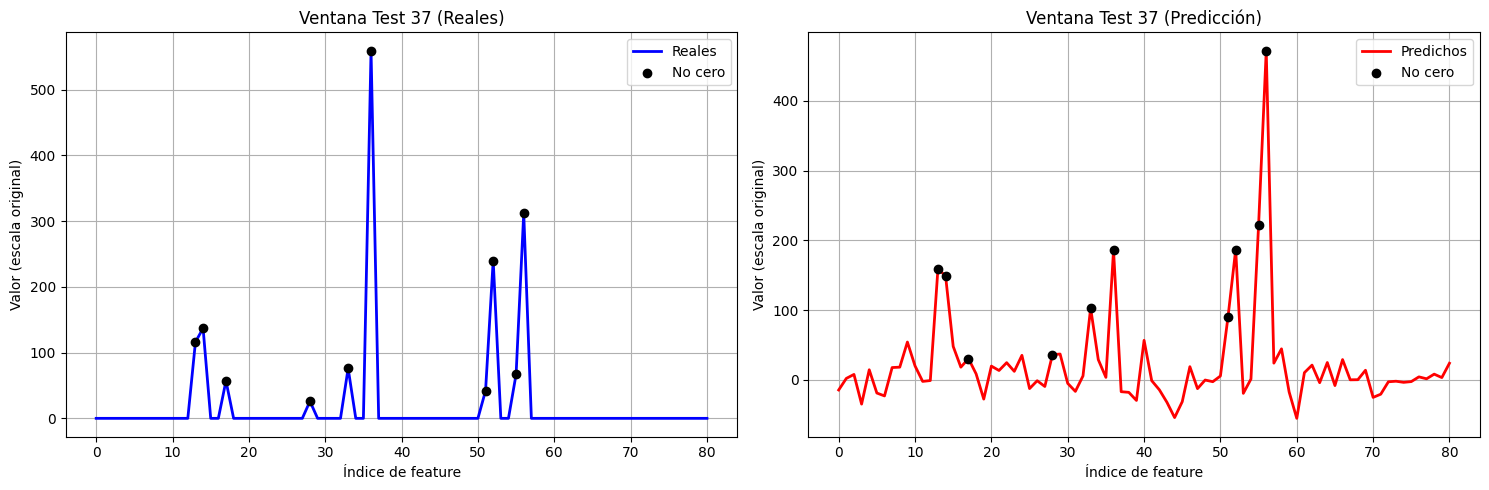

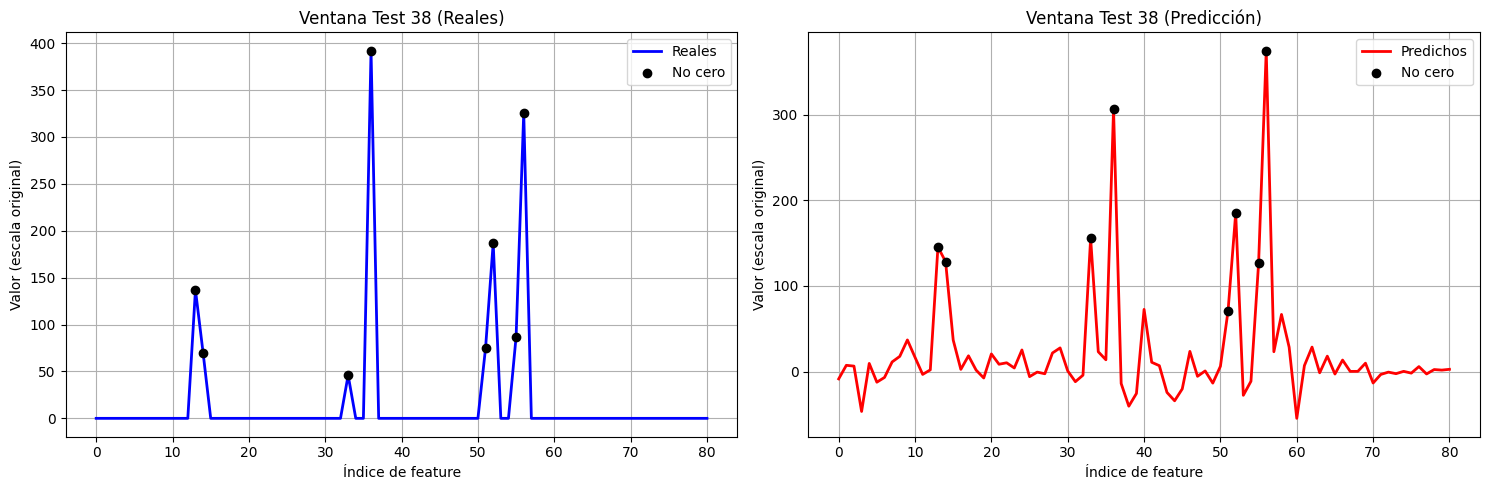

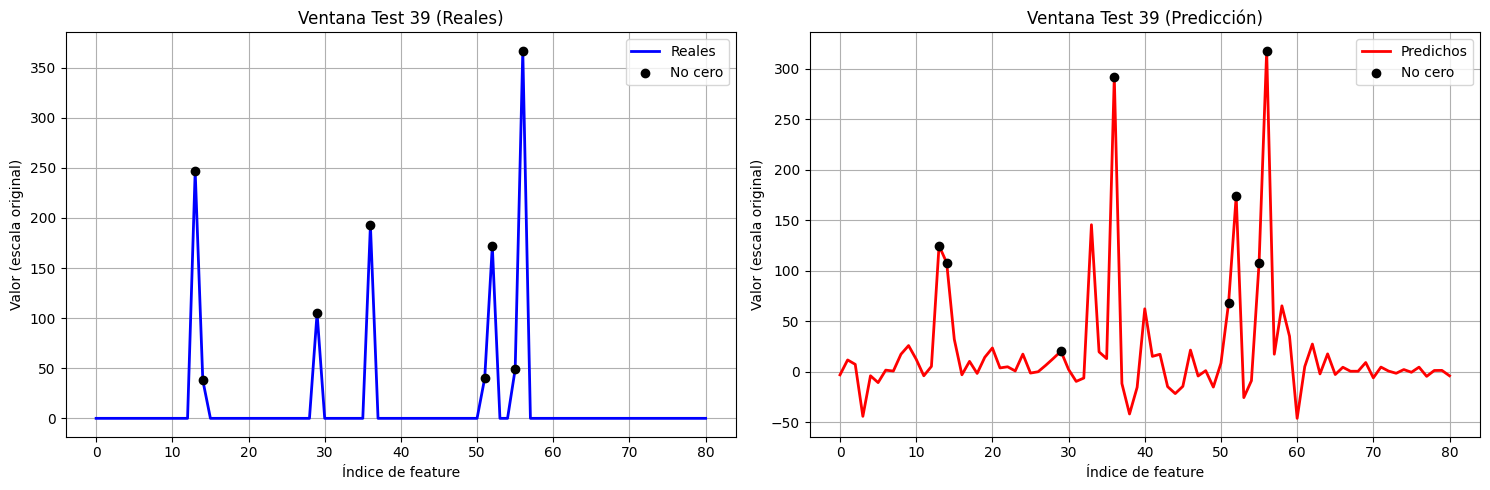

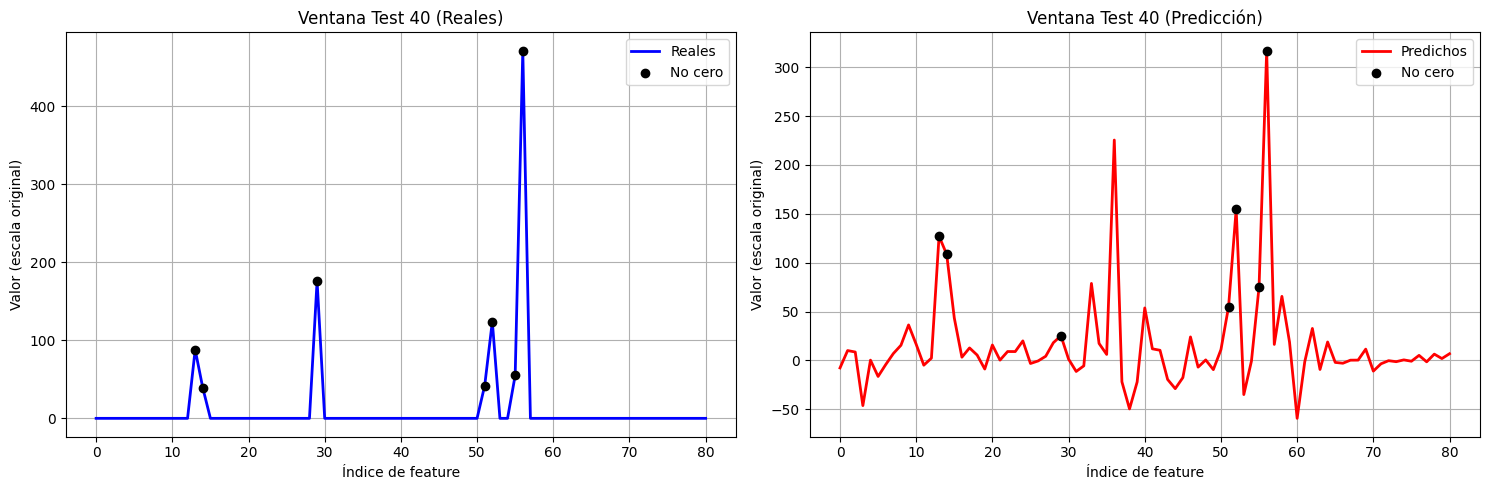

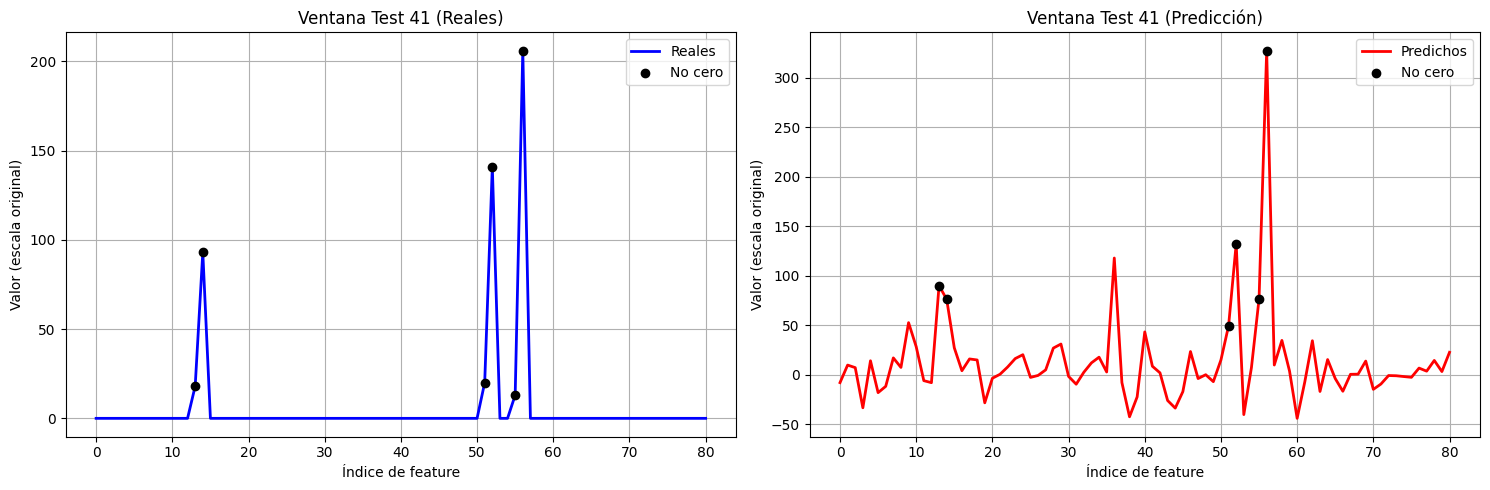

In [36]:
from torch.utils.data import Subset, DataLoader
import numpy as np

# Cargamos de nuevo el modelo si quieres asegurarte
model.load_state_dict(torch.load("Mejor_modelo_dcrnn.pth"))
model.eval()

test_size = len(test_dataset)
last_5_indices = list(range(test_size - 5, test_size))
last_5_subset = Subset(test_dataset, last_5_indices)
last_5_loader = DataLoader(last_5_subset, batch_size=5, shuffle=False)

nodo_idx = 135  # nodo que quieras visualizar
predictions_original = []
true_values_original = []

with torch.no_grad():
    for x_norm, A_norm, y_norm in last_5_loader:
        x_norm, A_norm, y_norm = x_norm.to(device), A_norm.to(device), y_norm.to(device)
        y_pred_norm = model(x_norm, A_norm)  # (5, 146, 1, 81)

        # Desnormaliza (similar a antes)
        # y = y_norm * (output_max - output_min) + output_min
        output_min_dev = output_min.to(device)
        output_max_dev = output_max.to(device)

        y_pred = y_pred_norm * (output_max_dev - output_min_dev) + output_min_dev
        y_real = y_norm      * (output_max_dev - output_min_dev) + output_min_dev

        predictions_original.append(y_pred.cpu())
        true_values_original.append(y_real.cpu())

predictions_original = torch.cat(predictions_original, dim=0)  # (5, num_nodes, 1, 81)
true_values_original = torch.cat(true_values_original, dim=0)  # (5, num_nodes, 1, 81)

# Extraemos los datos para el nodo elegido
pred_node = predictions_original[:, nodo_idx, 0, :]  # (5, 81)
true_node = true_values_original[:, nodo_idx, 0, :]  # (5, 81)

for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # REALES
    ax1.plot(true_node[i].numpy(), 'b-', label='Reales', linewidth=2)
    non_zero_idx = np.where(true_node[i].numpy() != 0)[0]
    ax1.scatter(non_zero_idx, true_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax1.set_title(f"Ventana Test {test_size - 5 + i} (Reales)")
    ax1.set_xlabel("Índice de feature")
    ax1.set_ylabel("Valor (escala original)")
    ax1.grid(True)
    ax1.legend()

    # PREDICHOS
    ax2.plot(pred_node[i].numpy(), 'r-', label='Predichos', linewidth=2)
    ax2.scatter(non_zero_idx, pred_node[i][non_zero_idx].numpy(),
                color='black', label='No cero', zorder=5)
    ax2.set_title(f"Ventana Test {test_size - 5 + i} (Predicción)")
    ax2.set_xlabel("Índice de feature")
    ax2.set_ylabel("Valor (escala original)")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    plt.close()

